Importujemy RoboticArm oraz inne potrzebne biblioteki

In [21]:
import numpy as np
import math
import matplotlib.pyplot as plt
from kinematics import RoboticArm

Tworzymy funckcję getTrajectory której parametry to:

1) moveTime - czyli czas ruchu z jednego miejsca do drugiego (skalar)
2) startPos - startowa pozycja końcówki nogi (wektor 3D w numpy)
3) endPos - końcowa pozycja końcówki nogi (wektor 3D w numpy)
4) startSpeed - prędkość końcowki nogi, z jaką zaczynamy ruch (wektor 3D w numpy, domyślnie same zera)
5) startSpeed - prędkość końcowki nogi, z jaką kończymy ruch (wektor 3D w numpy, domyślnie same zera)

Każda składowa x, y, z trajektorii będzie wyrażona przez wielomianem trzeciego stopnia od czasu.

Funkcja getTrajectory zwraca nam nie liczbę, a wielomian do którego możemy wrzucić czas t=t_p, a on wypluje nam wektor [x(t=t_p), y(t=t_p), z(t=t_p)]

Analogiczne, funkcje getSpeed i getAcceleration zwracają nam wielomiany odpowiednio prędkości i przyspieszenia końcowki nogi, które da sie wyliczyć znając współczynniki
wielomianów x(t), y(t), z(t) które zwraca funkcja getCoefficentsOfTrajectory.

In [66]:
def getCoefficentsOfTrajectory(moveTime, startPos, endPos, startSpeed, endSpeed):
    a0 = startPos
    a1 = startSpeed
    a3 = (1/(moveTime**3)) * (moveTime*(endSpeed-startSpeed) - 2*(endPos - startPos - moveTime*startSpeed))
    a2 = (1/(moveTime**2))*(endPos - a0 - a1*moveTime - a3*(moveTime**3))
    return np.array([a3, a2, a1, a0])

def getTrajectory(moveTime, startPos, endPos, startSpeed, endSpeed):
    coefficents = getCoefficentsOfTrajectory(moveTime, startPos, endPos, startSpeed, endSpeed)
    def trajectory(t):
        return np.polyval(coefficents, t)
    return trajectory

def getSpeed(moveTime, startPos, endPos, startSpeed, endSpeed):
    coefficents = getCoefficentsOfTrajectory(moveTime, startPos, endPos, startSpeed, endSpeed)
    a1 = coefficents[2]
    a2 = coefficents[1]
    a3 = coefficents[0]
    def speed(t):
        return np.polyval(np.array([3*a3, 2*a2, a1]), t)
    return speed

def getAcceleration(moveTime, startPos, endPos, startSpeed, endSpeed):
    coefficents = getCoefficentsOfTrajectory(moveTime, startPos, endPos, startSpeed, endSpeed)
    a2 = coefficents[1]
    a3 = coefficents[0]
    def acceleration(t):
        return np.polyval(np.array([6*a3, 2*a2]), t)
    return acceleration

Objaśnienie matematyczne:

Wyznaczymy składową x trajektorii (składowe y i z wyznacza się analogicznie).
Przyjmijmy ża a0, ... ,a3 oraz startPos, endPos, startSpeed i endSpeed to skalary,
bo rozpatrujemy teraz tylko jedną składową.

x(t) = a3 * x^3 + a2 * x^2 + a1 * x + a0    

Korzystając z równań:
startPos = x(0) = a0
startSpeed = x'(0) = a1

oraz

endPos = x(moveTime)
endSpeed = x'(moveTime)

możemy jednoznacznie wyznaczyć współczynniki wielomianu x(t).

In [88]:
moveTime=2
startPos=np.array([3,0,0])
endPos=np.array([0,2,-1])
startSpeed=np.array([0,0,0])
endSpeed=np.array([0,0,0])

trajectory = getTrajectory(moveTime, startPos, endPos, startSpeed, endSpeed)
speed = getSpeed(moveTime, startPos, endPos, startSpeed, endSpeed)
acceleration = getAcceleration(moveTime, startPos, endPos, startSpeed, endSpeed)

Wykres składowych tej trajektorii

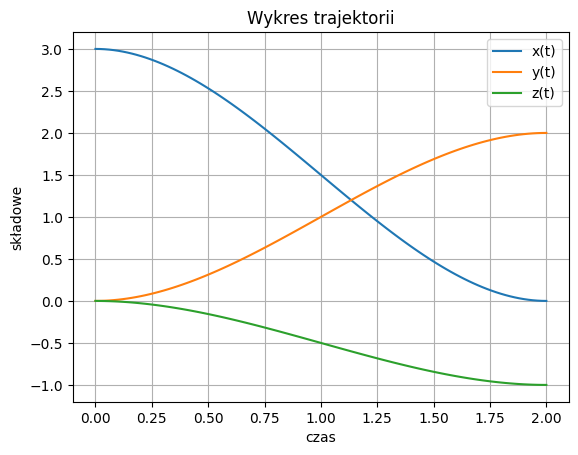

In [89]:
timeStamps = np.linspace(0, moveTime, 100)
plotTrajectory = np.array([trajectory(t) for t in timeStamps])

plt.plot(timeStamps, plotTrajectory[:,0], label='x(t)')
plt.plot(timeStamps, plotTrajectory[:,1], label='y(t)')
plt.plot(timeStamps, plotTrajectory[:,2], label='z(t)')
plt.title('Wykres trajektorii')
plt.xlabel('czas')
plt.ylabel('składowe')
plt.legend()
plt.grid(True)
plt.show()

Wykres składowych prędkości końcówki nogi (poruszającej się po tej trajektorii)

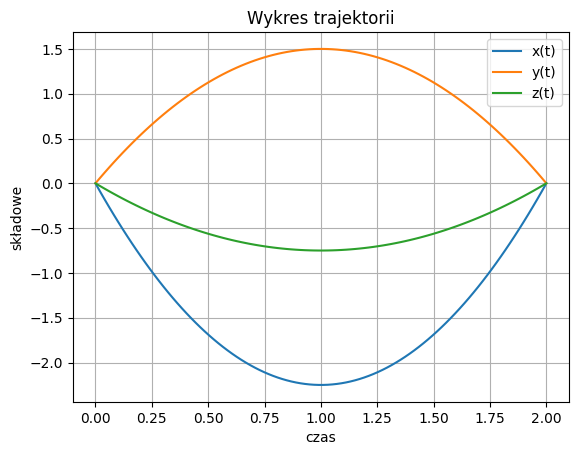

In [90]:
timeStamps = np.linspace(0, moveTime, 100)
plotSpeed = np.array([speed(t) for t in timeStamps])

plt.plot(timeStamps, plotSpeed[:,0], label='x(t)')
plt.plot(timeStamps, plotSpeed[:,1], label='y(t)')
plt.plot(timeStamps, plotSpeed[:,2], label='z(t)')
plt.title('Wykres trajektorii')
plt.xlabel('czas')
plt.ylabel('składowe')
plt.legend()
plt.grid(True)
plt.show()

Wykres składowych przyspieszeń końcówki nogi (poruszającej się po tej trajektorii)

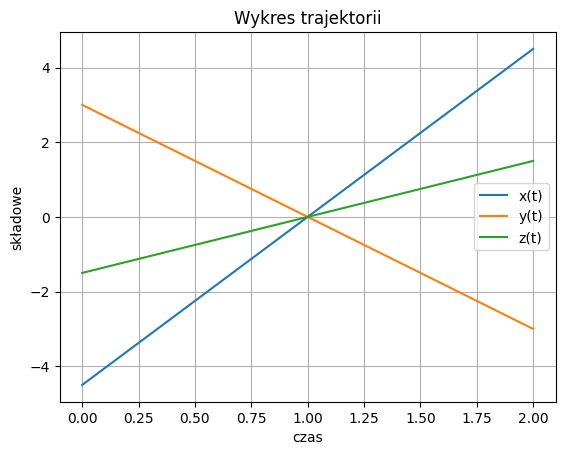

In [91]:
timeStamps = np.linspace(0, moveTime, 100)
plotAcceleration = np.array([acceleration(t) for t in timeStamps])

plt.plot(timeStamps, plotAcceleration[:,0], label='x(t)')
plt.plot(timeStamps, plotAcceleration[:,1], label='y(t)')
plt.plot(timeStamps, plotAcceleration[:,2], label='z(t)')
plt.title('Wykres trajektorii')
plt.xlabel('czas')
plt.ylabel('składowe')
plt.legend()
plt.grid(True)
plt.show()

UWAGA:

Jak widać, można łatwo wyznaczyć uzyskiwane w trakcie transformacji, maksymalną prędkość i przyspieszenie koncówki nogi.
Dzięki temu możemy wyliczyć je przed startem, i jeśli okaże się że prędkość lub przyspieszenie w pewnym momencie jest nieosiągalne dla serwomotorów,
to rzucić wyjątek i w prosty sposób wyznaczyć najkrótszy czas (dłuższy od zadanego), w którym końcówka nogi może przebyć drogę.

Spyta ktoś, po co interpolować składowe trajektorii wielomianami trzeciego stopnia. Czy nie lepiej zrobić prostą linię?
Otóż, bez takiej interpolacji nie moglibyśmy zadać początkowej i końcowej prędkości. Więc nie dość, że noga mogłaby "wbijać się" w ziemię,
to na dodatek przyspieszenie zamiast być liniowe, zmieniłoby się w jakąś deltę Diraca...

Najmniejszy stopień wielomianu, który pozwala nam interpolować trajektorię tak, by dało się narzuć prędkość poczatkową i koncową to stopień trzeci (a nie drugi!).

Trajektoria pokazana w 3D

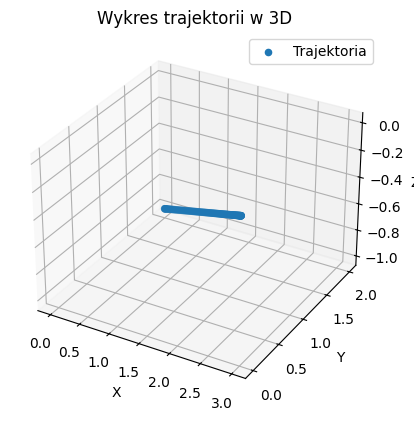

In [92]:
# Rysowanie wykresu punktów 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(plotTrajectory[:, 0], plotTrajectory[:, 1], plotTrajectory[:, 2], marker='o', label='Trajektoria')

# Ustawienia etykiet i tytułu
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Wykres trajektorii w 3D')

# Dodanie legendy
ax.legend()

# Wyświetlenie wykresu
plt.show()

Użycie kinematyki odwrotnej

steps oznacza liczbę kroków którymi dyskretyzujemy trajektorię (w czasie).

In [110]:
def convertPosition(position):
    assert len(position)==3
    return np.array([position[0], position[1], position[2], 1])


leg = RoboticArm(np.array([1, 0, 0, 1]), np.array([1, 0, 0, 1]), np.array([1, 0, 0, 1]), 0, -math.pi/2)
steps = 20
timeSteps = np.linspace(0, moveTime, steps)
posSteps = np.array([convertPosition(trajectory(t)) for t in timeSteps])
anglesSteps = np.array([leg.reverse(posStep) for posStep in posSteps])
print(anglesSteps)

[[ 0.00000000e+00  0.00000000e+00  1.57079633e+00]
 [ 5.38893470e-03  1.51005320e-01  1.26066962e+00]
 [ 2.12595216e-02  2.87986821e-01  9.62425736e-01]
 [ 4.77761162e-02  4.09675234e-01  6.77225727e-01]
 [ 8.58243206e-02  5.13450835e-01  4.06966078e-01]
 [ 1.36951074e-01  5.95052416e-01  1.54696591e-01]
 [ 2.03298333e-01  6.48324733e-01 -7.48815527e-02]
 [ 2.87410477e-01  6.65544017e-01 -2.74928244e-01]
 [ 3.91718941e-01  6.39592818e-01 -4.36422697e-01]
 [ 5.17456336e-01  5.69532427e-01 -5.49587363e-01]
 [ 6.62946984e-01  4.67622979e-01 -6.07716317e-01]
 [ 8.21974672e-01  3.58253471e-01 -6.11611902e-01]
 [ 9.83887177e-01  2.63759954e-01 -5.69831354e-01]
 [ 1.13650192e+00  1.92034942e-01 -4.94279432e-01]
 [ 1.27011682e+00  1.38648086e-01 -3.96670331e-01]
 [ 1.37958116e+00  9.60177306e-02 -2.88314477e-01]
 [ 1.46363035e+00  5.95708119e-02 -1.81167649e-01]
 [ 1.52299164e+00  2.91600699e-02 -8.83693618e-02]
 [ 1.55867170e+00  7.89296051e-03 -2.37539628e-02]
 [ 1.57079633e+00  1.11022302e-